In [3]:
import math
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np
import random

# This class creates a 8x8 board with a temperature field,
# normalized to have values roughly of the order of -5 to +5,
# changing over time due to the motion of heat sources which have
# a short-ranged influence on the temperature.
#
# An agent is moving over the board; the aim of the agent is to avoid extreme
# temperature zones in order to stay alive. (For that, see the Agent class below.)
#
class Surroundings:
    grid_size = 8  # 8x8 grid like a chessboard
    radius_of_sight = 2  # the agent can see two fields in each direction
    
    _num_heat_sources = 8  # how many heat sources there are on the board
    _v_square_per_source = 0.25  # mean square velocity of the heat sources
    
    _base_temperature = -5    # temperature in the absence of a heat source
    _influence_radius =  2.5  # radius within which an influence of the heat source is perceived
    _temperature_scale = 2.5  # maximum temperature increase due to a single heat source
    
    
    def __init__(self):
        self._debug_output = False
        self._temperature = np.zeros((Surroundings.grid_size, Surroundings.grid_size))
        acceptable_starting_configuration = False
        while not acceptable_starting_configuration:
            self._heat_source_position = [(random.uniform(0, Surroundings.grid_size), \
                                           random.uniform(0, Surroundings.grid_size)) \
                                          for i in range(Surroundings._num_heat_sources)]
            self._compute_temperature()
            self._agent_position = [random.randrange(1, Surroundings.grid_size - 1), \
                                    random.randrange(1, Surroundings.grid_size - 1)]
            T_start = self._temperature[self._agent_position[0], self._agent_position[1]]
            if T_start > -0.2* Surroundings._temperature_scale \
            and T_start < 0.2* Surroundings._temperature_scale:
                acceptable_starting_configuration = True
        self._heat_source_velocity = [(0, 0) for i in range(Surroundings._num_heat_sources)]
        for i in range(Surroundings._num_heat_sources):
            vi0 = random.uniform(0, Surroundings._v_square_per_source)**0.5
            if random.randrange(2) == 1:
                vi0 = -vi0
            vi1 = random.uniform(0, Surroundings._v_square_per_source)**0.5
            if random.randrange(2) == 1:
                vi1 = -vi1
            self._heat_source_velocity[i] = (vi0, vi1)
    
    def _compute_temperature(self):
        for x0 in range(Surroundings.grid_size):
            for x1 in range(Surroundings.grid_size):
                self._temperature[x0, x1] = Surroundings._base_temperature
                for (q0, q1) in self._heat_source_position:
                    distance = ((x0 - q0)**2 + (x1 - q1)**2)**0.5  # distance to heat source
                    if distance < Surroundings._influence_radius:  # add temperature contribution
                        self._temperature[x0][x1] += Surroundings._temperature_scale \
                        * (Surroundings._influence_radius - distance)
    
    def _move_heat_sources(self):
        for i in range(Surroundings._num_heat_sources):
            (qi0, qi1) = self._heat_source_position[i]
            (vi0, vi1) = self._heat_source_velocity[i]
            qi0 += vi0
            if qi0 < 0:  # hard-wall boundary condition in x0 direction
                qi0 = -qi0
                vi0 = -vi0
            if qi0 > Surroundings.grid_size:
                qi0 = 2*Surroundings.grid_size - qi0
                vi0 = -vi0
            qi1 += vi1
            if qi1 < 0:  # hard-wall boundary condition in x1 direction
                qi1 = -qi1
                vi1 = -vi1
            if qi1 > Surroundings.grid_size:
                qi1 = 2*Surroundings.grid_size - qi1
                vi1 = -vi1
            self._heat_source_position[i] = (qi0, qi1)
            self._heat_source_velocity[i] = (vi0, vi1)
        self._compute_temperature()
        if self._debug_output:
            print("Agent at:", self._agent_position, end="\t\t")
            print("Local temperature:", \
                  round(self._temperature[self._agent_position[0], self._agent_position[1]], 2))
    
    def activate_debug_output(self):
        self._debug_output = True
    
    def visualize(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(7, 7)
        plt.xticks(fontsize=18, color="#322300")
        plt.yticks(fontsize=18, color="#322300")
        ax.set_xlabel("coordinate x1", fontsize=24, color="#322300")
        ax.set_ylabel("coordinate x0", fontsize=24, color="#322300")
        im = plt.imshow(self._temperature, extent=[-0.5, Surroundings.grid_size-0.5, \
                                              Surroundings.grid_size-0.5, -0.5])
        cb = plt.colorbar()
        q0 = self._agent_position[0]
        q1 = self._agent_position[1]
        path = Path([[q1, q0+0.5], [q1+0.5, q0], [q1, q0-0.5], [q1-0.5, q0], [q1, q0+0.5]])
        patch = PathPatch(path, facecolor='#ff0000')
        ax.add_patch(patch)
    
    def perceive_local_temperature(self):
        return self._temperature[self._agent_position[0], self._agent_position[1]]
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x0 increased by one, and 1) with x0 increased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x0_higher(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0] + i + 1
            q1 = self._agent_position[1]
            if q0 < Surroundings.grid_size:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x0 decreased by one, and 1) with x0 decreased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x0_lower(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0] - i - 1
            q1 = self._agent_position[1]
            if q0 >= 0:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x1 increased by one, and 1) with x1 increased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x1_higher(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0]
            q1 = self._agent_position[1] + i + 1
            if q1 < Surroundings.grid_size:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) the position with x1 decreased by one, and 1) with x1 decreased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x1_lower(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0]
            q1 = self._agent_position[1] - i - 1
            if q1 >= 0:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # agent decides to increase x0 by one
    #
    def action_increment_x0(self):
        if self._agent_position[0] < Surroundings.grid_size - 1:
            self._agent_position[0] += 1
        else:
            print("\tWarning: action_increment_x0 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to decrease x0 by one
    #
    def action_decrement_x0(self):
        if self._agent_position[0] > 0:
            self._agent_position[0] -= 1
        else:
            print("\tWarning: action_decrement_x0 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to increase x1 by one
    #
    def action_increment_x1(self):
        if self._agent_position[1] < Surroundings.grid_size - 1:
            self._agent_position[1] += 1
        else:
            print("\tWarning: action_increment_x1 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to decrease x1 by one
    #
    def action_decrement_x1(self):
        if self._agent_position[1] > 0:
            self._agent_position[1] -= 1
        else:
            print("\tWarning: action_decrement_x1 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to sit around and do nothing
    #
    def action_wait(self):
        self._move_heat_sources()

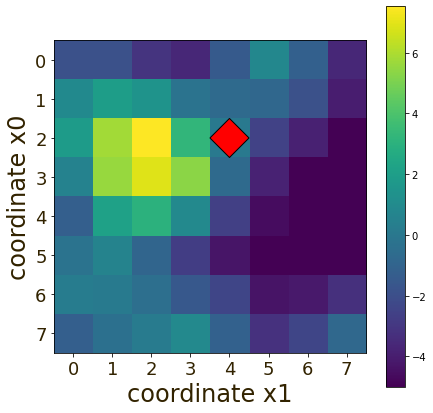

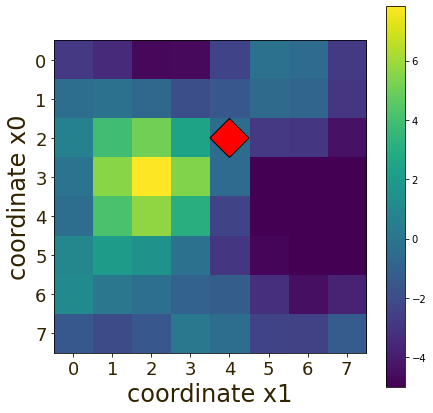

In [2]:
import time

landscape = Surroundings()
landscape.visualize()
for i in range(1):
    landscape._move_heat_sources()
landscape.visualize()

In [23]:
class Agent:
    temperature_tolerance = 4  # if temperature is outside the range from -4 to +4, the agent dies
    
    def __init__(self, landscape):
        self._alive = True
        self._environment = landscape
        self._timestep = 0
    
    # gather percepts
    #
    def sensor_input(self):
        self._local_temperature = self._environment.perceive_local_temperature()
        self._percept_x0_higher = self._environment.perceive_temperature_x0_higher()
        self._percept_x0_lower = self._environment.perceive_temperature_x0_lower()
        self._percept_x1_higher = self._environment.perceive_temperature_x1_higher()
        self._percept_x1_lower = self._environment.perceive_temperature_x1_lower()
        
        # check whether the agent dies due to extreme temperature
        #
        if abs(self._local_temperature) > Agent.temperature_tolerance:
            self._alive = False

    
    # keep gathering percepts and calling the agent function until, eventually, the agent dies
    #
    # the function returns the number of timesteps that it takes until the agent dies
    #
    def live_original(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_original()
            self.sensor_input()
        return self._timestep
    
    ## Tauheed A. Mir, Jamie Pickering, Jamie Liddiard
    def live_tauheed_mir_et_al(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_tauheed_mir_et_al()
            self.sensor_input()
        return self._timestep
    
    def live_justyna_kwiatkowska(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_justyna_kwiatkowska()
            self.sensor_input()
        return self._timestep
    
    def live_katib_hussain(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_katib_hussain()
            self.sensor_input()
        return self._timestep
    
    def live_justyna_kwiatkowska_edited(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_justyna_kwiatkowska_edited()
            self.sensor_input()
        return self._timestep
    
    def live_biased(self, bias):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function_biased(bias)
            self.sensor_input()
        return self._timestep
    
    
    # original agent function
    #
    # average life time: 18.3 steps
    #
    def agent_function_original(self):
        
        # look for a direction that decreases abs(temperature) and walk there
        #
        # we are using the percept for the temperature two fields away in each direction,
        # e.g., _percept_x0_higher[1] corresponds to the field with x0 increased by 2
        #
        if abs(self._percept_x0_higher[1]) < abs(self._local_temperature):
            self._environment.action_increment_x0()
        elif abs(self._percept_x0_lower[1]) < abs(self._local_temperature):
            self._environment.action_decrement_x0()
        elif abs(self._percept_x1_higher[1]) < abs(self._local_temperature):
            self._environment.action_increment_x1()
        elif abs(self._percept_x1_lower[1]) < abs(self._local_temperature):
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()

            
    # Tauheed A. Mir, Jamie Pickering, Jamie Liddiard
    #
    # average life time: 26.6 steps
    #
    def agent_function_tauheed_mir_et_al(self):
        
        # Collect known percepts as easy to type values
        currentSelectedTemp = abs(self._local_temperature)
        yPlus2 = self._percept_x1_higher[1]
        yPlus1 = self._percept_x1_higher[0]
        yMinus1 = self._percept_x1_lower[0]
        yMinus2 = self._percept_x1_lower[1]
        xPlus2 = self._percept_x0_higher[1]
        xPlus1 = self._percept_x0_higher[0]
        xMinus1 = self._percept_x0_lower[0]
        xMinus2 = self._percept_x0_lower[1]
        
        # 5x5 grid of percept values centered on AI
        tempGrid = [[    -10,     -10,             yMinus2,    -10,    -10], 
                    [    -10,     -10,             yMinus1,    -10,    -10], 
                    [xMinus2, xMinus1, currentSelectedTemp, xPlus1, xPlus2], 
                    [    -10,     -10,              yPlus1,    -10,    -10], 
                    [    -10,     -10,              yPlus2,    -10,    -10]]
        
        # Out of bounds checks
        # Positive Y
        if (math.isinf(yPlus1)):
            for i in range (5):
                tempGrid[4][i] = math.inf
                tempGrid[3][i] = math.inf
        elif (math.isinf(yPlus2)):
            for i in range (5):
                tempGrid[4][i] = math.inf
        # Negative Y
        if (math.isinf(yMinus1)):
            for i in range (5):
                tempGrid[0][i] = math.inf
                tempGrid[1][i] = math.inf
        elif (math.isinf(yMinus2)):
            for i in range (5):
                tempGrid[0][i] = math.inf
        # Positive X
        if (math.isinf(xPlus1)):
            for i in range (5):
                tempGrid[i][4] = math.inf
                tempGrid[i][3] = math.inf
        elif (math.isinf(xPlus2)):
            for i in range (5):
                tempGrid[i][4] = math.inf
        # Negative X
        if (math.isinf(xMinus1)):
            for i in range (5):
                tempGrid[i][0] = math.inf
                tempGrid[i][1] = math.inf
        elif (math.isinf(xMinus2)):
            for i in range (5):
                tempGrid[i][0] = math.inf
    
        # Guesses on squares with neighbours from known percepts            
        def FindAverage(tx, ty):
            count = 0
            total = 0
            if (math.isfinite(tempGrid[tx][ty])):
                for i in range (-1, 2, 1):
                    if ((tx + i) >= 0 and (tx + i) <= 4):
                        for j in range (-1, 2, 1):
                            if ((ty + j) >= 0 and (ty + j) <= 4):
                                if (tempGrid[tx+i][ty+j] != -10 and math.isfinite(tempGrid[tx+i][ty+j])):
                                    count += 1
                                    total += tempGrid[tx+i][ty+j]
            if (count != 0):
                tempGrid[tx][ty] = total/count
                
        # compute estimates for the 16 fields from tempGrid with unknown temperatures
        #
        # in that matrix, "2" is the present coordinate
        #
        FindAverage(1,1)
        FindAverage(3,1)
        FindAverage(1,3)
        FindAverage(3,3)
        
        FindAverage(1,0)
        FindAverage(0,1)
        FindAverage(0,3)
        FindAverage(1,4)
        FindAverage(3,4)
        FindAverage(4,3)
        FindAverage(4,1)
        FindAverage(3,0)
        
        FindAverage(0,0)
        FindAverage(4,0)
        FindAverage(0,4)
        FindAverage(4,4)
        
        # So now we get to do some logic to determine movement direction
        averageList = [0, 0, 0, 0, currentSelectedTemp]
        upAverage     = abs((tempGrid[0][0] + tempGrid[0][1] \
                             + tempGrid[0][2] + tempGrid[0][3] \
                             + tempGrid[0][4] + tempGrid[1][1] \
                             + tempGrid[2][1] + tempGrid[3][1]) / 8)
        downAverage   = abs((tempGrid[4][0] + tempGrid[4][1] \
                             + tempGrid[4][2] + tempGrid[4][3] \
                             + tempGrid[4][4] + tempGrid[3][1] \
                             + tempGrid[3][2] + tempGrid[3][3]) / 8)
        leftAverage   = abs((tempGrid[0][0] + tempGrid[1][0] + tempGrid[2][0] + tempGrid[3][0] + tempGrid[4][0] + tempGrid[1][1] + tempGrid[1][2] + tempGrid[1][3]) / 8)
        rightAverage  = abs((tempGrid[0][4] + tempGrid[1][4] + tempGrid[2][4] + tempGrid[3][4] + tempGrid[4][4] + tempGrid[1][3] + tempGrid[2][3] + tempGrid[3][3]) / 8)
        averageList[0] = upAverage
        averageList[1] = downAverage
        averageList[2] = leftAverage
        averageList[3] = rightAverage
        averageList.sort()

        if (averageList[0] == upAverage):
            self._environment.action_decrement_x1()
        if (averageList[0] == downAverage):
            self._environment.action_increment_x1()
        if (averageList[0] == leftAverage):
            self._environment.action_decrement_x0()
        if (averageList[0] == rightAverage):
            self._environment.action_increment_x0()
        if (averageList[0] == currentSelectedTemp):
            self._environment.action_wait()


    # average life time: 47.8 steps
    #
    def agent_function_justyna_kwiatkowska(self):
        
        # Consider the temperature of both tiles in each direction
        x0h = abs(self._percept_x0_higher[0]) + abs(self._percept_x0_higher[1])
        x0l = abs(self._percept_x0_lower[0]) + abs(self._percept_x0_lower[1])
        x1h = abs(self._percept_x1_higher[0]) + abs(self._percept_x1_higher[1])
        x1l = abs(self._percept_x1_lower[0]) + abs(self._percept_x1_lower[1])
        current = abs(self._local_temperature) * 2
        
        # Look for the direction with the lowest abs(temperature) and go there
        lowest = min(x0h, x0l, x1h, x1l, current)
        
        if (lowest == x0h):
            self._environment.action_increment_x0()
        elif (lowest == x0l):
            self._environment.action_decrement_x0()
        elif (lowest == x1h):
            self._environment.action_increment_x1()
        elif (lowest == x1l):
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()

    
    # average life time: 52.3 steps
    #
    def agent_function_katib_hussain(self):
        if abs(self._percept_x0_higher[0]) < abs(self._local_temperature):
            self._environment.action_increment_x0()
        elif abs(self._percept_x0_higher[1]) < abs(self._local_temperature) and \
        abs(self._percept_x0_higher[1]) < abs(self._percept_x0_higher[0]):
            self._environment.action_increment_x0()
            self._environment.action_increment_x0()
        elif abs(self._percept_x0_lower[0]) < abs(self._local_temperature):
            self._environment.action_decrement_x0()
        elif abs(self._percept_x0_lower[1]) < abs(self._local_temperature) and \
        abs(self._percept_x0_lower[1]) < abs(self._percept_x0_lower[0]):
            self._environment.action_decrement_x0()
            self._environment.action_decrement_x0()
        elif abs(self._percept_x1_higher[0]) < abs(self._local_temperature):
            self._environment.action_increment_x1()
        elif abs(self._percept_x1_higher[1]) < abs(self._local_temperature) and \
        abs(self._percept_x1_higher[1]) < abs(self._percept_x1_lower[0]):
            self._environment.action_increment_x1()
            self._environment.action_increment_x1()
        elif abs(self._percept_x1_lower[0]) < abs(self._local_temperature):
            self._environment.action_decrement_x1()
        elif abs(self._percept_x1_lower[1]) < abs(self._local_temperature) and \
        abs(self._percept_x1_lower[1]) < abs(self._percept_x1_lower[0]):
            self._environment.action_decrement_x1()
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()


    # like Justyna's function, but simplified:
    # We completely ignore the second fields (index [1])
    # and focus completely on the immediately adjacent fields (index [0])
    #
    # average life time: 133.6 steps
    #
    def agent_function_justyna_kwiatkowska_edited(self):
        
        x0h = abs(self._percept_x0_higher[0])
        x0l = abs(self._percept_x0_lower[0])
        x1h = abs(self._percept_x1_higher[0])
        x1l = abs(self._percept_x1_lower[0])
        current = abs(self._local_temperature)
        
        # Look for the direction with the lowest abs(temperature) and go there
        lowest = min(x0h, x0l, x1h, x1l, current)
        
        if (lowest == x0h):
            self._environment.action_increment_x0()
        elif (lowest == x0l):
            self._environment.action_decrement_x0()
        elif (lowest == x1h):
            self._environment.action_increment_x1()
        elif (lowest == x1l):
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()
    
    
    # Justyna's function, with the simplification above,
    # but extended by a bias; now we use abs(T - bias) instead of abs(T)
    #
    # for bias = -1/3 this leads to an average life time of 146.0 steps
    #
    def agent_function_biased(self, bias):
        
        x0h = abs(self._percept_x0_higher[0] - bias)
        x0l = abs(self._percept_x0_lower[0] - bias)
        x1h = abs(self._percept_x1_higher[0] - bias)
        x1l = abs(self._percept_x1_lower[0] - bias)
        current = abs(self._local_temperature - bias)
        
        # Look for the direction with the lowest abs(temperature - bias) and go there
        lowest = min(x0h, x0l, x1h, x1l, current)
        
        if (lowest == x0h):
            self._environment.action_increment_x0()
        elif (lowest == x0l):
            self._environment.action_decrement_x0()
        elif (lowest == x1h):
            self._environment.action_increment_x1()
        elif (lowest == x1l):
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()


Agent at: [5, 6]		Local temperature: 1.8
Agent at: [4, 6]		Local temperature: 2.03
Agent at: [5, 6]		Local temperature: 1.81
Agent at: [4, 6]		Local temperature: 0.29
Agent at: [4, 6]		Local temperature: 0.09
Agent at: [4, 6]		Local temperature: 0.34
Agent at: [4, 6]		Local temperature: 0.59
Agent at: [5, 6]		Local temperature: 2.01
Agent at: [4, 6]		Local temperature: 2.49
Agent at: [5, 6]		Local temperature: 0.04
Agent at: [5, 6]		Local temperature: -1.66
Agent at: [5, 6]		Local temperature: -2.79
Agent at: [6, 6]		Local temperature: -2.32
Agent at: [5, 6]		Local temperature: -3.16
Agent at: [6, 6]		Local temperature: -0.09
Agent at: [6, 6]		Local temperature: 0.75
Agent at: [6, 6]		Local temperature: 0.09
Agent at: [6, 6]		Local temperature: -1.0
Agent at: [6, 6]		Local temperature: -2.13
Agent at: [5, 6]		Local temperature: -1.64
Agent at: [5, 6]		Local temperature: -2.71
Agent at: [4, 6]		Local temperature: -2.95
Agent at: [3, 6]		Local temperature: -1.22
Agent at: [3, 6]		Local t

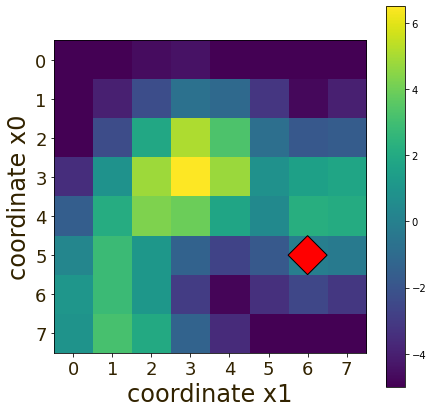

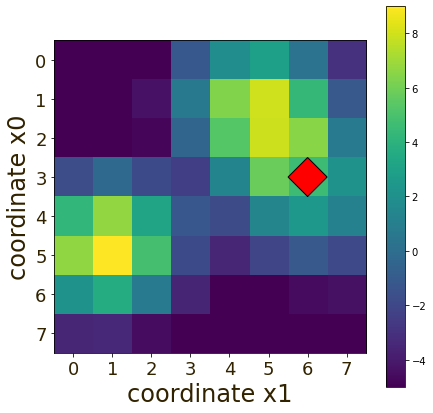

In [13]:
landscape = Surroundings()
landscape.activate_debug_output()
landscape.visualize()

agent = Agent(landscape)
time = agent.live_original()
print("\n****\nThe agent died after", time, "steps")

landscape.visualize()

In [11]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_original()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	6	6.0
100	19	19.228
200	25	18.289
300	14	18.628
400	18	18.908
500	43	18.729
600	7	18.541
700	15	18.465
800	10	18.557
900	83	18.541
1000	27	18.273
1100	5	18.215
1200	16	18.439
1300	18	18.336
1400	6	18.275
1500	26	18.185
1600	6	18.066
1700	22	18.049
1800	7	18.052
1900	8	18.12
2000	40	18.065
2100	14	18.212
2200	50	18.129
2300	13	18.173
2400	9	18.176
2500	7	18.242
2600	15	18.302
2700	10	18.348
2800	19	18.34
2900	13	18.387
3000	18	18.373
3100	7	18.325
3200	19	18.358
3300	22	18.371
3400	25	18.338
3500	8	18.256
3600	12	18.251
3700	28	18.313
3800	11	18.329
3900	28	18.309
4000	4	18.328
4100	18	18.359
4200	16	18.394
4300	27	18.384
4400	54	18.419
4500	25	18.361
4600	12	18.456
4700	5	18.445
4800	28	18.379
4900	17	18.356
****
Average life: 18.333 steps


In [18]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_tauheed_mir_et_al()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	73	73.0
100	3	28.099
200	4	27.697
300	12	27.442
400	3	28.362
500	10	28.479
600	7	28.106
700	15	27.285
800	4	26.963
900	5	27.198
1000	47	27.144
1100	56	27.062
1200	31	27.171
1300	17	27.179
1400	50	26.935
1500	24	26.85
1600	3	26.681
1700	28	26.735
1800	13	26.716
1900	5	26.858
2000	7	26.764
2100	38	26.576
2200	5	26.506
2300	8	26.266
2400	21	26.294
2500	28	26.363
2600	9	26.376
2700	3	26.307
2800	4	26.393
2900	13	26.399
3000	94	26.416
3100	58	26.376
3200	2	26.325
3300	7	26.223
3400	48	26.104
3500	4	26.142
3600	8	26.121
3700	38	26.193
3800	110	26.225
3900	58	26.148
4000	22	26.041
4100	48	26.013
4200	36	26.114
4300	40	26.137
4400	6	26.155
4500	3	26.028
4600	35	25.968
4700	8	25.964
4800	59	25.979
4900	17	25.987
****
Average life: 25.98 steps


In [9]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_justyna_kwiatkowska()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	2	2.0
100	119	49.188
200	21	46.279
300	48	48.538
400	53	49.975
500	19	49.19
600	32	48.175
700	33	47.959
800	81	49.17
900	64	49.036
1000	195	50.067
1100	245	50.507
1200	5	50.349
1300	75	49.686
1400	87	49.458
1500	15	49.475
1600	189	49.6
1700	113	49.698
1800	49	49.934
1900	73	49.378
2000	25	49.239
2100	63	49.442
2200	37	49.701
2300	45	49.366
2400	30	49.442
2500	22	49.38
2600	65	49.213
2700	3	49.137
2800	168	49.285
2900	32	49.33
3000	46	48.932
3100	33	48.732
3200	109	48.374
3300	135	48.272
3400	27	48.245
3500	37	48.304
3600	239	48.192
3700	23	48.14
3800	64	48.142
3900	143	47.993
4000	85	47.894
4100	14	48.002
4200	90	48.056
4300	29	47.934
4400	75	47.834
4500	51	47.912
4600	47	47.934
4700	7	48.016
4800	31	47.882
4900	22	47.734
****
Average life: 47.765 steps


In [7]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_katib_hussain()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	59	59.0
100	57	47.337
200	3	51.692
300	82	52.266
400	77	52.918
500	27	53.339
600	6	53.363
700	22	53.05
800	82	52.675
900	14	52.635
1000	37	52.479
1100	34	52.539
1200	6	52.873
1300	76	52.728
1400	9	52.35
1500	165	52.898
1600	39	52.563
1700	11	52.143
1800	6	51.47
1900	12	51.638
2000	120	51.337
2100	202	51.423
2200	167	51.713
2300	6	51.847
2400	97	52.302
2500	73	51.889
2600	83	51.738
2700	45	51.415
2800	54	51.54
2900	73	51.643
3000	77	51.825
3100	6	51.809
3200	91	51.635
3300	15	51.575
3400	90	51.555
3500	29	51.383
3600	25	51.32
3700	8	51.357
3800	128	51.565
3900	163	51.551
4000	26	51.615
4100	53	51.629
4200	13	51.857
4300	42	52.06
4400	129	51.929
4500	22	51.899
4600	13	51.924
4700	177	51.908
4800	23	52.109
4900	86	52.338
****
Average life: 52.288 steps


In [11]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_justyna_kwiatkowska_edited()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	134	134.0
100	48	145.277
200	255	147.557
300	110	136.528
400	29	134.771
500	50	133.519
600	17	129.454
700	107	128.499
800	25	131.055
900	205	130.083
1000	4	132.301
1100	335	132.433
1200	12	130.887
1300	265	131.052
1400	34	130.957
1500	127	131.526
1600	286	131.435
1700	28	129.559
1800	199	130.411
1900	107	129.373
2000	74	130.102
2100	156	130.296
2200	37	129.717
2300	155	130.382
2400	228	130.164
2500	36	129.364
2600	94	129.358
2700	95	130.05
2800	473	129.929
2900	350	129.37
3000	119	129.97
3100	36	130.074
3200	52	130.296
3300	1086	130.885
3400	46	130.408
3500	9	130.738
3600	74	130.834
3700	136	130.629
3800	59	130.712
3900	224	131.46
4000	308	131.9
4100	160	132.78
4200	50	133.024
4300	313	132.914
4400	292	133.049
4500	69	133.307
4600	244	133.849
4700	36	134.156
4800	335	134.222
4900	70	133.781
****
Average life: 133.602 steps


In [29]:
import numpy as np

repetitions = 500

average_lifetime = {}

for bias in np.arange(-0.9, 0.301, 0.03):
    total_life = 0
    for i in range(repetitions):
        landscape = Surroundings()
        agent = Agent(landscape)
        this_life = agent.live_biased(bias)
        total_life += this_life
    average_lifetime[bias] = total_life/repetitions
    print(round(bias, 3), round(average_lifetime[bias], 3), sep="\t")


-0.9	115.914
-0.87	126.0
-0.84	113.056
-0.81	129.654
-0.78	125.81
-0.75	142.628
-0.72	144.242
-0.69	135.728
-0.66	136.72
-0.63	132.272
-0.6	129.656
-0.57	135.776
-0.54	139.258
-0.51	139.156
-0.48	146.148
-0.45	149.396
-0.42	140.67
-0.39	142.812
-0.36	152.75
-0.33	140.85
-0.3	142.042
-0.27	132.782
-0.24	139.768
-0.21	137.22
-0.18	135.838
-0.15	139.368
-0.12	142.204
-0.09	144.074
-0.06	139.48
-0.03	136.832
0.0	140.086
0.03	138.778
0.06	132.842
0.09	126.94
0.12	133.238
0.15	120.564
0.18	127.146
0.21	119.3
0.24	130.346
0.27	113.878
0.3	118.16


<AxesSubplot:xlabel='temperature bias (i.e., preferred temperature level)', ylabel='average lifetime (in number of steps)'>

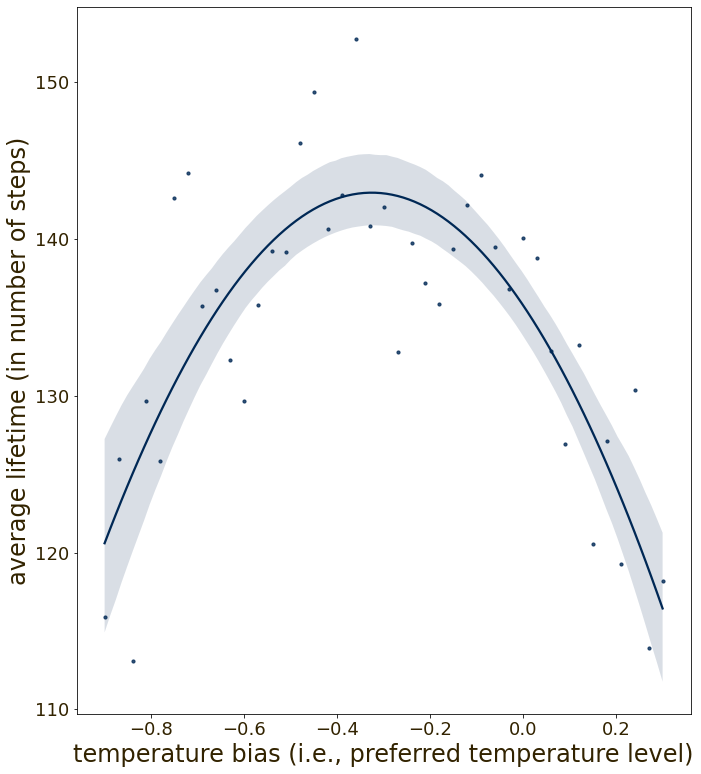

In [33]:
import seaborn as sbn
import matplotlib.pyplot as plt

keylist_lifetime = list(average_lifetime.keys())
vallist_lifetime = list(average_lifetime.values())

fig, ax = plt.subplots()
fig.set_size_inches(11, 13)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("temperature bias (i.e., preferred temperature level)", fontsize=24, color="#322300")
ax.set_ylabel("average lifetime (in number of steps)", fontsize=24, color="#322300")

sbn.regplot(x=keylist_lifetime, y=vallist_lifetime, \
            color='#002855', order=2, scatter_kws={'s':10})  # blue for mergesort

In [31]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live_biased(-1/3)
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	150	150.0
100	107	147.703
200	48	150.303
300	23	143.611
400	88	135.793
500	42	142.11
600	54	142.712
700	42	145.026
800	182	144.318
900	124	147.326
1000	457	146.886
1100	500	146.45
1200	174	147.743
1300	8	148.03
1400	374	146.547
1500	73	145.588
1600	368	144.766
1700	15	144.878
1800	123	144.485
1900	51	146.205
2000	101	145.317
2100	3	144.699
2200	40	144.511
2300	94	144.558
2400	67	143.895
2500	153	144.381
2600	26	144.945
2700	279	145.659
2800	177	145.231
2900	31	144.774
3000	526	146.679
3100	21	146.371
3200	28	146.471
3300	170	146.223
3400	62	146.856
3500	41	146.191
3600	128	146.032
3700	262	146.105
3800	13	146.31
3900	18	145.946
4000	255	145.372
4100	139	145.342
4200	236	145.53
4300	505	145.535
4400	63	145.344
4500	71	145.641
4600	154	145.86
4700	134	146.088
4800	286	146.406
4900	63	146.16
****
Average life: 145.984 steps
